In [ ]:
!nvidia-smi

Mon Feb 21 17:29:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install simpletransformers
!pip install tensorboardx
!pip install stop_words

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval

In [ ]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


In [ ]:
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [ ]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [ ]:
from dont_patronize_me import DontPatronizeMe


In [ ]:
dpm = DontPatronizeMe('.', '.')

In [ ]:
dpm.load_task1()
dpm.load_task2(return_one_hot=True)

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


In [ ]:
pd.set_option('display.max_colwidth',1000)

In [ ]:
dpm.train_task1_df

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , as I 'm pretty sure most people are aware . For a while , waking up every day to check the news seemed to carry with it the same feeling of panic and dread that action heroes probably face when they 're trying to decide whether to cut the blue or green wire on a ticking bomb -- except the bomb 's instructions long ago burned in a fire and imminent catastrophe seems the likeliest outcome . It 's hard to stay that on-edge for that long , though , so it 's natural for people to become inured to this constant chaos , to slump into a malaise of hopelessness and pessimism .",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of Ghanaian and Nigerian immigrants . These are the two countries with key macroeconomic challenges including unemployment . Let 's tackle this issue from the root and not the fruit . Thank you",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said that the focus of immigration actions would be illegal immigrants """" who have also otherwise violated our laws """" .""",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displayed . Two of the spaces would be reserved for disabled persons and there would be five P30 spaces and eight P60 ones .,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El Salvador and Guatemala in the ' 80s and ' 90s , just like we 've seen thousands of economic refugees , we started seeing Mexicans fleeing the violence in Ju ? rez and other parts of Mexico , """" says shelter director Ruben Garcia .""",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women from taking part in beauty pageants because of the pressure from family but Amritaa urges young hopefuls to try and convince their families , get their support , and take part in a beauty contest """" because it gives a platform to show one 's skills and talent . """" Her success should be an inspiration .""",0,1
10465,10466,@@70091353,vulnerable,ph,"He added that the AFP will continue to bank on the application of the whole of nation -- whole of government approach , which involves the use of sustainable and peaceful engagements with vulnerable communities to protect them from further NPA exploitation .",0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and information can go out to places that really need to know what 's going on in her hometown . She has always availed not only her platform , her voice , but also resources -- tangible resources -- to help those most in need in Houston and around . """"""",1,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word to describe how I feel for you .... May God almighty keep blessing you and always give you strength and sound health to continue your good work ..... You gave hope to the hopeless ! ! ! ! Have so much respect for you .. Stay Blessed my good fellow ... """" says one commenter on Facebook . """" God bless you and your mission . Glad to see Hope ( and all the children ) growing up loved , well fed , happy , having fun , and going to school , """" says another .""",1,4


In [ ]:
dpm.train_task1_df['label'].value_counts()

0    9476
1     993
Name: label, dtype: int64

In [ ]:
from statistics import mean
lenlist = [len(x) for x in dpm.train_task1_df['text']]
avglen = mean([len(x) for x in dpm.train_task1_df['text']])
print(avglen)

267.58286369280734


In [ ]:
lenlist

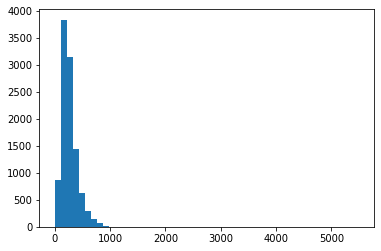

In [ ]:
import matplotlib.pyplot as plt
plt.hist(lenlist, bins=50)
plt.show()

In [ ]:
dpm.load_task2()

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


In [ ]:
dpm.train_task2_df

,par_id,art_id,text,keyword,country,label
0,4046,@@14767805,We also know that they can benefit by receiving counseling from someone who can help them understand that their feelings are normal and that their situation is not hopeless ; someone who can help them put their situation in perspective and help them communicate with others who could provide support ; someone knowledgeable about resources they can access ; someone who can help them plan for their needs and the needs of their child by developing either a parenting plan or an adoption plan .,hopeless,us,"[1, 0, 0, 1, 0, 0, 0]"
1,1279,@@7896098,"Pope Francis washed and kissed the feet of Muslim , Orthodox , Hindu and Catholic refugees in a moving ceremony during Holy Thursday Mass at a refugee centre on the outskirts of Rome . ( March 24 )",refugee,ng,"[0, 1, 0, 0, 0, 0, 0]"
2,8330,@@17252299,"Many refugees do n't want to be resettled anywhere , let alone in the US .",refugee,ng,"[0, 0, 1, 0, 0, 0, 0]"
3,4063,@@3002894,"""Budding chefs , like """" Fred """" , """" Winston """" and """" Angela """" in the kitchen are either homeless or recently re-housed - and desperately in need of a helping hand to enable them to re-build their shattered lives .""",in-need,ie,"[1, 0, 0, 1, 1, 1, 0]"
4,4089,@@25597822,"""In a 90-degree view of his constituency , one can see a high rise and a flyover while underneath it , homeless people sleep on pavements . """" As you can see , my constituency is not confined to one socio-economic group , """" he said , adding that apart from water , another major concern for him is to improve the standard of public schools in the area .""",homeless,pk,"[1, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...
988,873,@@20374243,"Citing the fact that these kids who died at Gorakhpur 's Baba Raghav Das ( BRD ) Medical College and Farrukhabad district hospital belonged to the poor families , the Shiv Sena said instead of acting as a ' God ' to the poor ' , these government hospitals are proving to be a ' God of death ' for them .",poor-families,sg,"[1, 0, 0, 0, 1, 0, 0]"
989,10070,@@15573661,"Fern ? ndez was a well-known philanthropist who never forgot his motherland and was honoured by the former King of Spain , Juan Carlos , for his charitable deeds , including his work with disabled young people .",disabled,ng,"[1, 0, 0, 0, 0, 0, 0]"
990,6484,@@2559173,"Touched much by their plight , Commanding Officer and all ranks of the 7 Sri Lanka Light Infantry ( SLLI ) Regiment serving under the Security Fore Headquarters - Kilinochchi ( SFHQ-KLN ) , offered their financial and labour support for construction of a new house to a homeless family in Kanakapuram , Kilinochchi.",homeless,lk,"[1, 0, 0, 0, 0, 1, 0]"
991,6249,@@1947926,She reiterated her ministry 's commitment to put in place the necessary legal and policy framework to address all issues that affect women 's rights and gave a strong indication of hope for Ghanaian women .,women,gh,"[1, 0, 0, 0, 0, 0, 0]"


# Data selection

In [ ]:
data_df = pd.DataFrame(dpm.train_task1_df[['text','keyword','label']])
data_df.head(5)

,text,keyword,label
0,"We 're living in times of absolute insanity , as I 'm pretty sure most people are aware . For a while , waking up every day to check the news seemed to carry with it the same feeling of panic and dread that action heroes probably face when they 're trying to decide whether to cut the blue or green wire on a ticking bomb -- except the bomb 's instructions long ago burned in a fire and imminent catastrophe seems the likeliest outcome . It 's hard to stay that on-edge for that long , though , so it 's natural for people to become inured to this constant chaos , to slump into a malaise of hopelessness and pessimism .",hopeless,0
1,"In Libya today , there are countless number of Ghanaian and Nigerian immigrants . These are the two countries with key macroeconomic challenges including unemployment . Let 's tackle this issue from the root and not the fruit . Thank you",migrant,0
2,"""White House press secretary Sean Spicer said that the focus of immigration actions would be illegal immigrants """" who have also otherwise violated our laws """" .""",immigrant,0
3,Council customers only signs would be displayed . Two of the spaces would be reserved for disabled persons and there would be five P30 spaces and eight P60 ones .,disabled,0
4,""""""" Just like we received migrants fleeing El Salvador and Guatemala in the ' 80s and ' 90s , just like we 've seen thousands of economic refugees , we started seeing Mexicans fleeing the violence in Ju ? rez and other parts of Mexico , """" says shelter director Ruben Garcia .""",refugee,0


In [ ]:
data_df['label'].value_counts()

0    9476
1     993
Name: label, dtype: int64

In [ ]:
# get count of pcl instances
pcldf = data_df[data_df.label==1]
num_pcl_instances = len(pcldf)
print(num_pcl_instances)

# downsample non-pcl instances (from a ratio of ~ 10:1, we make it 3:1)
# training_set1 = pd.concat([pcldf,data_df[data_df.label==0][:num_pcl_instances*3]])
training_set1 = data_df
print(len(training_set1))

993
10469


# Paraphrasing

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained("Vamsi/T5_Paraphrase_Paws")  
model = AutoModelForSeq2SeqLM.from_pretrained("Vamsi/T5_Paraphrase_Paws")
model = model.to("cuda")

def paraphrase_instance(sentence):
  text =  "paraphrase: " + sentence + " </s>"
  encoding = tokenizer.encode_plus(text,pad_to_max_length=True, return_tensors="pt")
  input_ids, attention_masks = encoding["input_ids"].to("cuda"), encoding["attention_mask"].to("cuda")

  outputs = model.generate(
      input_ids=input_ids, attention_mask=attention_masks,
      max_length=256,
      do_sample=True,
      no_repeat_ngram_size=2, 
      top_k=120,
      top_p=0.95,
      early_stopping=True,
      num_return_sequences=8
  )

  lines = []
  for output in outputs:
      line = tokenizer.decode(output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
      if line.lower()!=sentence and line.lower() not in lines:
        lines.append(line.lower())
        # return line

  return lines

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

In [ ]:
paraphrase_df = training_set1

In [ ]:
training_set1.loc[0]

text       we re living in times of absolute insanity as i m pretty sure most people are aware for a while waking up every day to check the news seemed to carry with it the same feeling of panic and dread that action heroes probably face when they re trying to decide whether to cut the blue or green wire on a ticking bomb except the bomb s instructions long ago burned in a fire and imminent catastrophe seems the likeliest outcome it s hard to stay that on edge for that long though so it s natural for people to become inured to this constant chaos to slump into a malaise of hopelessness and pessimism
keyword                                                                                                                                                                                                                                                                                                                                                                                                  

In [ ]:
ctr = 0
for i in range(len(training_set1)):
  # print(i)
  if training_set1.iloc[i].label==1:
    ctr+=1
    print(ctr)
    # paraphrased_sentence = paraphrase_instance(training_set1.iloc[i].text)
    paraphrased_list = paraphrase_instance(training_set1.iloc[i].text)
    # # print("original text")
    # # print(training_set1.loc[i,'text'])
    # # print("paraphrased text")
    # # print(paraphrased_sentence)
    # paraphrased_row = {'text': paraphrased_sentence, 'keyword': training_set1.iloc[i].keyword, 'label': 1}
    for line in paraphrased_list:
      paraphrased_row = {'text': line, 'keyword': training_set1.iloc[i].keyword, 'label': 1}
      paraphrase_df = paraphrase_df.append(paraphrased_row, ignore_index = True)

In [ ]:
len(paraphrase_df)

18234

In [ ]:
paraphrase_df.tail()

,text,keyword,label
18229,immediately tweeted guinness world record 540lbs 7 layer munchy monstrosity la s midnight mission homeless donating threw,homeless,1
18230,guinness world record 540lbs 7 layer munchy monstrosity tweeted immediately la s midnight mission homeless good day,homeless,1
18231,tweeted guinness world record 540lbs 7 layer munchy monstrosity immediately delivered la s midnight mission homeless good day,homeless,1
18232,tweet instantly delivering guinness world record 540lbs 7 layer munchy monstrosity good day la mission midnight,homeless,1
18233,guinness world record 540lbs 7 layer munchy monstrosity tweeted immediately midnight mission homeless good day,homeless,1


In [ ]:
training_set1[training_set1['label']==1].tail()

,text,keyword,label
10444,more than 150 volunteers spent the night in survival camps to highlight the plight of refugees this winter,refugee,1
10453,we are challenged i suggest to turn this time of celebration into a sustained commitment of awareness and care for those for whom each day is an act of survival said mr higgins thanking those who work to support the vulnerable,vulnerable,1
10466,she has one huge platform and information can go out to places that really need to know what s going on in her hometown she has always availed not only her platform her voice but also resources tangible resources to help those most in need in houston and around,in-need,1
10467,anja ringgren loven i ca n t find a word to describe how i feel for you may god almighty keep blessing you and always give you strength and sound health to continue your good work you gave hope to the hopeless have so much respect for you stay blessed my good fellow says one commenter on facebook god bless you and your mission glad to see hope and all the children growing up loved well fed happy having fun and going to school says another,hopeless,1
10468,guinness world record of 540lbs of 7 layer munchy monstrosity he tweeted delivered immediately to la s midnight mission for the homeless a good day,homeless,1


In [ ]:
paraphrase_df.to_csv('newparadf.csv', index=False)

# Load Paraphrased csv file

In [ ]:
paraphrase_df = pd.read_csv('newparadf.csv')
paraphrase_df

,text,keyword,label
0,re living times absolute insanity m pretty sure people aware waking every day check news seemed carry feeling panic dread action heroes probably face re trying decide whether cut blue green wire ticking bomb except bomb s instructions long ago burned fire imminent catastrophe seems likeliest outcome s hard stay edge long though s natural people become inured constant chaos slump malaise hopelessness pessimism,hopeless,0
1,libya today countless number ghanaian nigerian immigrants two countries key macroeconomic challenges including unemployment let s tackle issue root fruit thank,migrant,0
2,white house press secretary sean spicer said focus immigration actions illegal immigrants also otherwise violated laws,immigrant,0
3,council customers signs displayed two spaces reserved disabled persons five p30 spaces eight p60 ones,disabled,0
4,just like received migrants fleeing el salvador guatemala 80s 90s just like ve seen thousands economic refugees started seeing mexicans fleeing violence ju rez parts mexico says shelter director ruben garcia,refugee,0
...,...,...,...
18229,immediately tweeted guinness world record 540lbs 7 layer munchy monstrosity la s midnight mission homeless donating threw,homeless,1
18230,guinness world record 540lbs 7 layer munchy monstrosity tweeted immediately la s midnight mission homeless good day,homeless,1
18231,tweeted guinness world record 540lbs 7 layer munchy monstrosity immediately delivered la s midnight mission homeless good day,homeless,1
18232,tweet instantly delivering guinness world record 540lbs 7 layer munchy monstrosity good day la mission midnight,homeless,1


# Preprocess text

In [ ]:
paraphrase_df = paraphrase_df.dropna()

In [ ]:
paraphrase_df.loc[:,"text"] = paraphrase_df.text.apply(lambda x : str.lower(x))
# training_set1.loc[:,"text"] = training_set1.text.apply(lambda x : str.lower(x))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
import re
paraphrase_df.loc[:,"text"] = paraphrase_df.text.apply(lambda x : " ".join(re.findall('[\w]+',x)))
# training_set1.loc[:,"text"] = training_set1.text.apply(lambda x : " ".join(re.findall('[\w]+',x)))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
from stop_words import get_stop_words
stop_words = get_stop_words('en')

def remove_stopWords(s):
    '''For removing stop words
    '''
    s = ' '.join(word for word in s.split() if word not in stop_words)
    return s

paraphrase_df.loc[:,"text"] = paraphrase_df.text.apply(lambda x: remove_stopWords(x))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
paraphrase_df = paraphrase_df.sample(frac=1).reset_index(drop=True)

In [ ]:
paraphrase_df.label.value_counts()

0    9475
1    8758
Name: label, dtype: int64

# Stratified K-Fold Splits

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# T5-Model

In [ ]:
from simpletransformers.t5 import T5Args, T5Model

In [ ]:
paraphrase_df['label'] = paraphrase_df['label'].astype(str)

In [ ]:
#Adding keyword to text
key_col = paraphrase_df["keyword"].copy()
 
# concatenating team with name column
# overwriting name column
paraphrase_df["text"]= paraphrase_df["text"].str.cat(key_col, sep =",")

In [ ]:
paraphrase_df['prefix'] = "binary classification"

In [ ]:
task1_model_args = T5Args(num_train_epochs=1, no_save=True, no_cache=True, overwrite_output_dir=True)
X = paraphrase_df['text']
y = paraphrase_df['label']

skf = StratifiedKFold(n_splits=5, random_state=27, shuffle=True)

accuracy = []
zero_recall = []
one_recall = []
zero_precision = []
one_precision = []
zero_f1 = []
one_f1 = []
for train_index, test_index in skf.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  # print(type(X_train))
  frame = {'input_text':X_train, 'target_text':y_train}
  train_set = pd.DataFrame(frame)
  train_set['prefix']="binary classification"

  frame = {'input_text':X_test, 'target_text':y_test}
  valid_set = pd.DataFrame(frame)

  task1_model = T5Model("t5", 't5-base', args = task1_model_args, num_labels=2, use_cuda=cuda_available)
  # train model
  task1_model.train_model(train_set)
  # run predictions
  preds_task1 = task1_model.predict(valid_set['input_text'].tolist())
  clf_report = classification_report(valid_set['target_text'],preds_task1, output_dict=True)
  accuracy.append(clf_report['accuracy'])
  zero_recall.append(clf_report['0']['recall'])
  one_recall.append(clf_report['1']['recall'])
  zero_precision.append(clf_report['0']['precision'])
  one_precision.append(clf_report['1']['precision'])
  zero_f1.append(clf_report['0']['f1-score'])
  one_f1.append(clf_report['1']['f1-score'])

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/14586 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3478: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
INFO:simpletransformers.t5.t5_model: Training started


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/1824 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


KeyboardInterrupt: ignored

In [ ]:
task1_model_args = T5Args(num_train_epochs=1, no_save=True, no_cache=True, overwrite_output_dir=True)
X = paraphrase_df['text']
y = paraphrase_df['label']

skf = StratifiedKFold(n_splits=5, random_state=27, shuffle=True)

accuracy = []
zero_recall = []
one_recall = []
zero_precision = []
one_precision = []
zero_f1 = []
one_f1 = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# X_train, X_test = X[train_index], X[test_index]
# y_train, y_test = y[train_index], y[test_index]
# print(type(X_train))
frame = {'input_text':X_train, 'target_text':y_train}
train_set = pd.DataFrame(frame)
train_set['prefix']="binary classification"

frame = {'input_text':X_test, 'target_text':y_test}
valid_set = pd.DataFrame(frame)

task1_model = T5Model("t5", 't5-base', args = task1_model_args, num_labels=2, use_cuda=cuda_available)
# train model
task1_model.train_model(train_set)
# run predictions
preds_task1 = task1_model.predict(valid_set['input_text'].tolist())
clf_report = classification_report(valid_set['target_text'],preds_task1, output_dict=True)
accuracy.append(clf_report['accuracy'])
zero_recall.append(clf_report['0']['recall'])
one_recall.append(clf_report['1']['recall'])
zero_precision.append(clf_report['0']['precision'])
one_precision.append(clf_report['1']['precision'])
zero_f1.append(clf_report['0']['f1-score'])
one_f1.append(clf_report['1']['f1-score'])

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/12216 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3478: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
INFO:simpletransformers.t5.t5_model: Training started


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/1527 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.t5.t5_model: Training of t5-base model complete. Saved to outputs/.


Generating outputs:   0%|          | 0/753 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3478: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Decoding outputs:   0%|          | 0/6018 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from statistics import mean
print("Mean Accuracy:", mean(accuracy[:-1]))
print("Recall (class-0):", mean(zero_recall[:-1]))
print("Recall (class-1):", mean(one_recall[:-1]))
print("Precision (class-0):", mean(zero_precision[:-1]))
print("Precision (class-1):", mean(one_precision[:-1]))
print("F1-score (class-0):", mean(zero_f1[:-1]))
print("F1-score (class-1):", mean(one_f1[:-1]))

Mean Accuracy: 0.7635951661631419
Recall (class-0): 0.9068791946308725
Recall (class-1): 0.5484886649874056
Precision (class-0): 0.7523779270880672
Precision (class-1): 0.7994997485485402
F1-score (class-0): 0.8223424266291472
F1-score (class-1): 0.650171620323624


In [ ]:
print(one_recall)

[0.8611013679410733]


# Predict on Task-1 Test Set

## Train on entire train+valid set

In [ ]:
paraphrase_df.head()

,text,keyword,label,prefix
0,"california species special concern burrowing owls nest ground makes especially vulnerable,vulnerable",vulnerable,0,binary classification
1,"chief inspector nicola shepherd led investigation said number years men placed position trust carried prolonged abuse significant number vulnerable young people,vulnerable",vulnerable,0,binary classification
2,"maiduguri nigeria two female suicide bombers killed least 35 people camp made homeless boko haram s extremist insurgency northeast nigeria state official said wednesday latest violence hit region,homeless",homeless,0,binary classification
3,"n t ignore contribution migrants un,migrant",migrant,0,binary classification
4,"since bangladeshs main export us clothing industry employs 4 million workers 90 girls poor families earnings empowered now contributions allow siblings go schools give respected voices home s empowerment also helping reduce poverty population growth increase literacy,poor-families",poor-families,1,binary classification


In [ ]:
frame = {'input_text':paraphrase_df['text'], 'target_text':paraphrase_df['label'], 'prefix': paraphrase_df['prefix']}
final_train_df = pd.DataFrame(frame)

In [ ]:
final_train_df

,input_text,target_text,prefix
0,"california species special concern burrowing owls nest ground makes especially vulnerable,vulnerable",0,binary classification
1,"chief inspector nicola shepherd led investigation said number years men placed position trust carried prolonged abuse significant number vulnerable young people,vulnerable",0,binary classification
2,"maiduguri nigeria two female suicide bombers killed least 35 people camp made homeless boko haram s extremist insurgency northeast nigeria state official said wednesday latest violence hit region,homeless",0,binary classification
3,"n t ignore contribution migrants un,migrant",0,binary classification
4,"since bangladeshs main export us clothing industry employs 4 million workers 90 girls poor families earnings empowered now contributions allow siblings go schools give respected voices home s empowerment also helping reduce poverty population growth increase literacy,poor-families",1,binary classification
...,...,...,...
18229,"harvey n t acting alone harvey n t allowed enabled kadian women without help said noble s attorney jeff herman,women",0,binary classification
18230,"intense focus latino issues driven donald trump republican front runner described mexican immigrants criminals pledged build wall along border,immigrant",0,binary classification
18231,"dozen students walk classroom university houston campus laying pens envelopes stamps re preparing call mail flood writing hundreds letters governor greg abbott expressing support syrian refugees,refugee",0,binary classification
18232,"aspect constitution required court several occasions assess policy adopted government seminal early case government rsa others v grootboom others 49 court held government s housing policy breach obligations imposed upon government section 26 constitution failed provide form relief desperately need access housing 50 ordered government amend program provide relief people access land roof heads living intolerable conditions crisis situations 51,in-need",1,binary classification


In [ ]:
# Using the same model configuration as before
task1_model_args = T5Args(num_train_epochs=1, no_save=True, no_cache=True, overwrite_output_dir=True)

# Create a T5 Model
task1_model = T5Model("t5", 't5-base', args = task1_model_args, num_labels=2, use_cuda=cuda_available)

# Train the model
task1_model.train_model(final_train_df)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/18234 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3478: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
INFO:simpletransformers.t5.t5_model: Training started


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/2280 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.t5.t5_model: Training of t5-base model complete. Saved to outputs/.


(2280, nan)

## Predict

In [ ]:
test_df = pd.read_csv('task4_test.tsv',sep='\t', names=["id", "art_id", "keyword", "country", "text"])
test_df.head()

,id,art_id,keyword,country,text
0,t_0,@@7258997,vulnerable,us,"In the meantime , conservatives are working to weaken Clinton and drive down her numbers in early voting states , where she is increasingly vulnerable . They are , in effect , doing Sanders 's dirty work for him while he avoids scrutiny ."
1,t_1,@@16397324,women,pk,"In most poor households with no education children are a matter of routine . The house maid industry is a sorry tale of dysfunctional families . The norm of these families is to make their women and children work while the men do not work , are on drugs , and either just abuse their wives or produce more children ."
2,t_2,@@16257812,migrant,ca,"The real question is not whether immigration is good for the country or bad for the country . The real question is the intent of the immigrant . It is a subtle point , and one that is very easy to miss ."
3,t_3,@@3509652,migrant,gb,"In total , the country 's immigrant population has grown by 4.1million from 2011 to 2015 ."
4,t_4,@@477506,vulnerable,ca,"Members of the church , which is part of Ken Copeland Ministries , had recently traveled abroad and contracted measles . Church-members who were not vaccinated were particularly vulnerable to catching the rare disease , according to Healthline ."


In [ ]:
test_df['keyword'].value_counts()

refugee          416
women            412
vulnerable       400
immigrant        400
in-need          399
homeless         394
hopeless         385
migrant          371
disabled         332
poor-families    323
Name: keyword, dtype: int64

In [ ]:
#Preprocess test data
test_df.loc[:,"text"] = test_df.text.apply(lambda x : str.lower(x))
test_df.loc[:,"text"] = test_df.text.apply(lambda x : " ".join(re.findall('[\w]+',x)))
test_df.loc[:,"text"] = test_df.text.apply(lambda x: remove_stopWords(x))

In [ ]:
#Adding keyword to text
keyword_column = test_df["keyword"].copy()
 
# concatenating team with name column
# overwriting name column
test_df["text"]= test_df["text"].str.cat(keyword_column, sep =",")

In [ ]:
test_df = test_df[['text']]

In [ ]:
test_df

,text
0,"meantime conservatives working weaken clinton drive numbers early voting states increasingly vulnerable effect sanders s dirty work avoids scrutiny,vulnerable"
1,"poor households education children matter routine house maid industry sorry tale dysfunctional families norm families make women children work men work drugs either just abuse wives produce children,women"
2,"real question whether immigration good country bad country real question intent immigrant subtle point one easy miss,migrant"
3,"total country s immigrant population grown 4 1million 2011 2015,migrant"
4,"members church part ken copeland ministries recently traveled abroad contracted measles church members vaccinated particularly vulnerable catching rare disease according healthline,vulnerable"
...,...
3827,"letter dated thursday european commission president jean claude juncker prime minister viktor orban said fences erected 2015 borders serbia croatia practically eliminated migrant flow hungary guard just country,migrant"
3828,"discovered poor families healthier kids collecting small crabs shrimp rice paddies grinding kids food feeding smaller frequent meals,poor-families"
3829,"married 19 milan emil badovinac immigrant malinci now bosnia herzegovina 12 years senior arranged marriage ten months later became mother emil sonny second son nicky born 1942,migrant"
3830,"united kingdom n t going devolve something seen movies like children men country literally shut borders rounded illegal immigrants become viciously anti immigrant s pure dystopia s brexit s people saying want country back s racist xenophobic s common sense uk still going allow immigration re still going trade nations europe re still going deal eu s end world folks given liberal media obsessed race n t shocked re smearing entire leave camp bunch xenophobic troglodytes,immigrant"


In [ ]:
predictions = task1_model.predict(test_df['text'].to_list())

Generating outputs:   0%|          | 0/479 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3478: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Decoding outputs:   0%|          | 0/3832 [00:00<?, ?it/s]

In [ ]:
predictions

In [ ]:
labels2file(predictions, 'task1.txt')

In [ ]:
!cat task1.txt | head -n 100